# Aprendizagem de máquina 

In [ ]:
from datetime import date
#@title Um breve estudo sobre o banco: *drug_consumption*
#@markdown ---
#@markdown #### Autores
Discente_1 = 'Manuel Ferreira Junior- 20180008601' #@param {type:"string"}
Discente_2 = 'Caroline Assis de Oliveira - 20180011385' #@param {type: "string"}
#@markdown ---
Data = '2021-11-22' #@param {type:"date"}
#@markdown ---

# Imports

In [183]:
# basics
import os 
import time
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm

# viz
import seaborn as sns
import matplotlib.pyplot as plt

# utils
from scipy.stats import wilcoxon
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# models
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# metrics and selection
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report,adjusted_rand_score

# Lendo base dados

In [96]:
DIR, FILE = 'data', 'drug.data'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data'
url_data = os.path.join(DIR,FILE)
r = requests.get(url, allow_redirects=True)
if not os.path.exists(DIR):
  os.makedirs(DIR)
open(url_data, 'wb').write(r.content)

346695

In [97]:
data = pd.read_csv(url_data, header=None)
data.columns = ['id', 'age', 'gender', 'education', 'country', 'ethnicity',
                'nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impulssive',
                'ss', 'alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis',
                'choc', 'coke', 'crack', 'ecstasy', 'heroin', 'ketamine', 'legalh',
                'lsd', 'meth', 'mushrooms', 'nicotine', 'semer', 'vsa']
data.set_index('id', drop=True, inplace=True)
data.drop(["ethnicity"],axis=1, inplace = True)
data.head()

,age,gender,education,country,nscore,escore,oscore,ascore,cscore,impulssive,ss,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [98]:
data.shape

(1885, 30)

In [99]:
c = data.columns
for i in c:
  LE = LabelEncoder()
  data[i] = LE.fit_transform(data[i]) # transformando as strings em valores numerico
data.head()

,age,gender,education,country,nscore,escore,oscore,ascore,cscore,impulssive,ss,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2,1,5,6,27,19,16,17,24,3,2,5,2,0,2,6,0,5,0,0,0,0,0,0,0,0,0,2,0,0
2,1,0,8,6,17,35,29,28,23,2,5,5,2,2,0,6,4,6,3,0,4,0,2,0,2,3,0,4,0,0
3,2,0,5,6,19,28,14,12,16,1,7,6,0,0,0,6,3,4,0,0,0,0,0,0,0,0,1,0,0,0
4,0,1,7,6,22,17,20,27,28,1,2,4,0,0,3,5,2,4,2,0,0,0,2,0,0,0,0,2,0,0
5,2,1,8,6,31,11,17,21,32,3,5,4,1,1,0,6,3,6,0,0,1,0,0,1,0,0,2,2,0,0


In [100]:
for drug in data.columns[11:]:
  data[drug][data[drug] > 0] = 1
data.head()

,age,gender,education,country,nscore,escore,oscore,ascore,cscore,impulssive,ss,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2,1,5,6,27,19,16,17,24,3,2,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,8,6,17,35,29,28,23,2,5,1,1,1,0,1,1,1,1,0,1,0,1,0,1,1,0,1,0,0
3,2,0,5,6,19,28,14,12,16,1,7,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0
4,0,1,7,6,22,17,20,27,28,1,2,1,0,0,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0
5,2,1,8,6,31,11,17,21,32,3,5,1,1,1,0,1,1,1,0,0,1,0,0,1,0,0,1,1,0,0


In [101]:
a = data[data.columns[11:]].drop(['caff','choc','alcohol','nicotine'],axis=1)
a_new = a.sum(axis=1)
a_new[a_new>0] = 1
data['used'] = a_new

In [104]:
data.used.value_counts()/data.shape[0]

1    0.841379
0    0.158621
Name: used, dtype: float64

# Analise descritiva

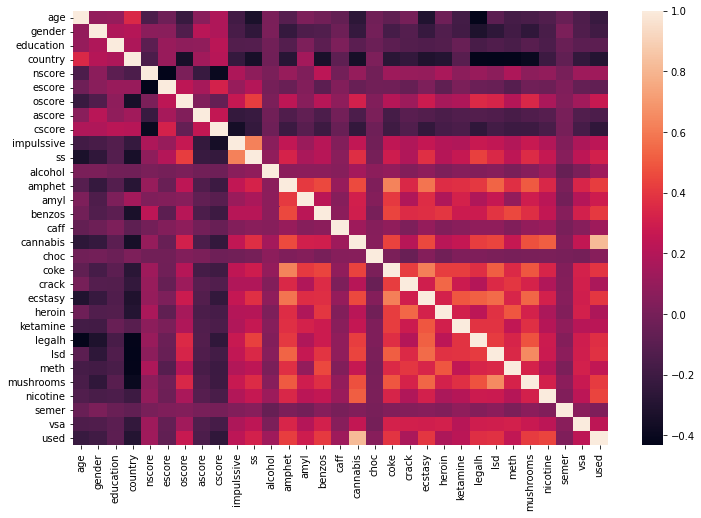

In [134]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr())
plt.show()

In [135]:
y_name = 'used'
data[y_name].value_counts()
# 0: não usuario de entorpecente ilicito
# 1: usuario de entorpecente ilicito

1    1586
0     299
Name: used, dtype: int64

# Visualização de dados

In [142]:
data_drugs = data[data.columns[11:]]
data_drugs[y_name] = data[y_name]
data_drugs.drop(['caff','choc','alcohol','nicotine'],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [154]:
hall_names_head = data_drugs.sum().sort_values(ascending=False)[1:6]
hall_names_head.index

Index(['cannabis', 'amphet', 'mushrooms', 'benzos', 'ecstasy'], dtype='object')

In [149]:
data_str = data.copy()
for  c in data.iloc[:,11:].columns:
    data_str[c][data_str[c] > 0] = 1

In [166]:
data_str.drop(['alcohol','caff','choc','nicotine'],axis=1,inplace=True)
data_str.columns

Index(['age', 'gender', 'education', 'country', 'nscore', 'escore', 'oscore',
       'ascore', 'cscore', 'impulssive', 'ss', 'amphet', 'amyl', 'benzos',
       'cannabis', 'coke', 'crack', 'ecstasy', 'heroin', 'ketamine', 'legalh',
       'lsd', 'meth', 'mushrooms', 'semer', 'vsa', 'used'],
      dtype='object')

In [156]:
hall_names_head.index

Index(['cannabis', 'amphet', 'mushrooms', 'benzos', 'ecstasy'], dtype='object')

In [171]:
df = data_str.groupby(['gender', 'education']).sum().iloc[:,9:]
df[hall_names_head.index]

cannabis  amphet  mushrooms  benzos  ecstasy
gender education                                              
0      0                13       9         10      10        8
       1                46      36         25      27       27
       2                16      13         14       9       11
       3                60      42         40      34       46
       4               325     216        241     195      232
       5               110      70         70      66       63
       6               149     110        107      95       89
       7                84      49         46      46       43
       8                23      17         16      21       17
1      0                 9       9          5       9        7
       1                19      12          7      17        9
       2                 9       7          6       7        7
       3                26      11         13      14       11
       4               148      79         85      91       89
       5                78      46         40      56       37
       6               198     109        107     105      106
       7               118      50         52      59       43
       8                41      24         19      24       19

<Figure size 864x576 with 0 Axes>

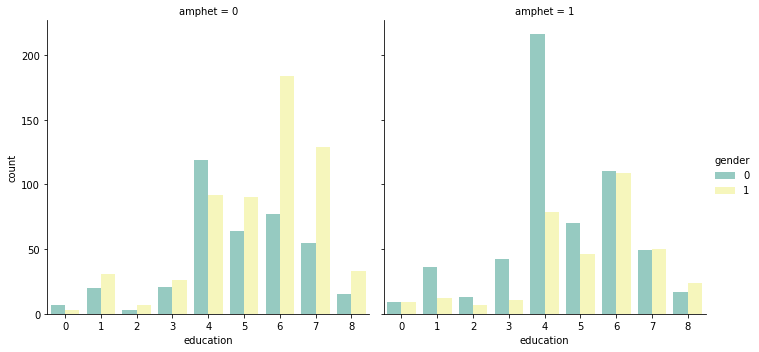

In [174]:
plt.figure(figsize=(12,8))
#sns.barplot(data=data_str, x='education', y='heroin', palette='Set3')
sns.catplot(data=data_str,kind="count",
            x='education',hue='gender',
            col = 'amphet',#'cannabis',#'meth',#'lsd',#'legalh', #vsa, nicotine
            palette='Set3')
plt.show()

## Teste de wilcoxon

In [176]:
gp0 = data_str[data_str.gender == 0].groupby(['education'],axis=0).sum().iloc[:,10:]
gp1 = data_str[data_str.gender == 1].groupby(['education'],axis=0).sum().iloc[:,10:]

gp0 - gp1

,amphet,amyl,benzos,cannabis,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,semer,vsa,used
education,,,,,,,,,,,,,,,,
0,0,2,1,4,0,-1,1,-2,2,0,2,1,5,0,1,3
1,24,13,10,27,22,3,18,8,10,19,21,8,18,-1,8,21
2,6,5,2,7,7,3,4,3,1,2,10,0,8,-1,3,7
3,31,14,20,34,19,14,35,11,22,35,28,19,27,1,18,32
4,137,64,104,177,112,49,143,50,76,189,144,93,156,1,75,176
5,24,29,10,32,20,3,26,11,22,36,29,11,30,0,8,20
6,1,1,-10,-49,-12,8,-17,7,9,15,6,15,0,-2,3,-67
7,-1,-6,-13,-34,-11,-5,0,-5,-2,3,-4,-6,-6,0,-4,-41
8,-7,0,-3,-18,-2,2,-2,3,3,0,4,9,-3,0,-4,-19


In [179]:
pvalues = {}
for name in gp0.columns:
    pvalues[name] = round(wilcoxon(gp0[name] - gp1[name])[1], 4)
    
df_pvalues = pd.DataFrame(pvalues.values(), index=pvalues.keys(), columns=['p-value'])
df_pvalues.sort_values('p-value',ascending=True)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,p-value
ketamine,0.0176
lsd,0.0177
legalh,0.0180
meth,0.0251
heroin,0.0378
amyl,0.0499
mushrooms,0.0499
crack,0.0654
amphet,0.0793
ecstasy,0.0929


# Split  dos dados

## ADASYN

In [184]:
y_name = 'used'
cols = list(a.columns) + [y_name]

In [185]:
X = data.drop(cols,axis=1)
Y = pd.DataFrame(data[y_name])

In [198]:
Y.value_counts()

used
1       1586
0        299
dtype: int64

In [199]:
ada = ADASYN()
X_resampled, y_resampled = ada.fit_resample(X, Y)

In [200]:
y_resampled.value_counts()

used
1       1586
0       1560
dtype: int64

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

# Modelagem

## Classificação

### Decision Tree Classifier

In [227]:
param_grid_dtc = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [100,200,300,400,500,600],
    'min_samples_leaf': [5,50,100,200,300,500]
}

In [228]:
dtc = DecisionTreeClassifier()
clf = GridSearchCV(dtc, param_grid_dtc, cv=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [231]:
dtc = DecisionTreeClassifier(**clf.best_params_)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=400, min_samples_leaf=5)

In [232]:
X_train.columns

Index(['age', 'gender', 'education', 'country', 'nscore', 'escore', 'oscore',
       'ascore', 'cscore', 'impulssive', 'ss', 'alcohol', 'caff', 'choc',
       'nicotine'],
      dtype='object')

In [233]:
features_importances = pd.DataFrame(dtc.feature_importances_,
                                    columns=['importances'],
                                    index=X_train.columns)
# Ranking top 5 variáveis mais influentes sobre a árvore de decisão
features_importances.sort_values('importances', ascending=False).head()

,importances
nicotine,0.445775
oscore,0.108716
cscore,0.063647
nscore,0.060504
escore,0.058708


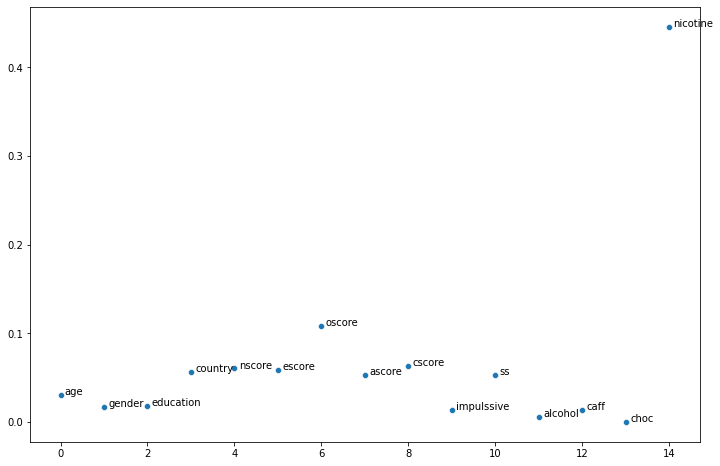

In [234]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=range(features_importances.shape[0]),
                y=features_importances.values.reshape((1,-1))[0])
for i in range(features_importances.shape[0]):
    plt.text(x = i + 0.1,
            y = features_importances.values[i],
            s='{}'.format(features_importances.index[i]))

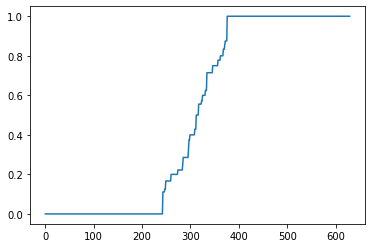

In [278]:
plt.plot(range(X_test.shape[0]),np.sort(dtc.predict_proba(X_test)[:,1]))
plt.show()

In [250]:
confusion_matrix(y_test, y_pred)

array([[263,  35],
       [ 49, 283]])

In [251]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       298
           1       0.89      0.85      0.87       332

    accuracy                           0.87       630
   macro avg       0.87      0.87      0.87       630
weighted avg       0.87      0.87      0.87       630



#### Validação cruzada

In [252]:
start = time.time()

accuracies = []
precision_0, precision_1 = [], []
recall_0, recall_1 = [], []
K = 5
skf = StratifiedKFold(n_splits=K)

ada = ADASYN()
X_resampled, y_resampled = ada.fit_resample(X, Y)
for train_index, test_index in tqdm(skf.split(X_resampled, y_resampled)):
    X_air_train, X_air_test = X_resampled.values[train_index], X_resampled.values[test_index]
    y_air_train, y_air_test = y_resampled.values[train_index], y_resampled.values[test_index]
    model = DecisionTreeClassifier(**clf.best_params_)
    model.fit(X_air_train, y_air_train)
    y_air_pred = model.predict(X_air_test)
    #acc = accuracy_score(y_air_test, y_air_pred)
    #accuracies.append(acc)
    cm = confusion_matrix(y_air_test, y_air_pred)
    print(cm)
    # Acuracia
    acc = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    accuracies.append(acc)
    # Precisão por classe
    prec_0 = cm[0,0]/(cm[0,0] + cm[1,0])
    prec_1 = cm[1,1]/(cm[1,1] + cm[0,1])
    precision_0.append(prec_0), precision_1.append(prec_1)
    # Recall por classe
    rec_0 = cm[0,0]/(cm[0,0] + cm[0,1])
    rec_1 = cm[1,1]/(cm[1,1] + cm[1,0])
    recall_0.append(rec_0), recall_1.append(rec_1)

print('Acc: {0:.4} | Std: {1:.4}'.format(np.mean(accuracies), np.std(accuracies)))
print('Recall [0]: {0:.4} | Recall [1]: {1:.4}'.format(np.mean(recall_0), np.mean(recall_1)))
print('Precision [0]: {0:.4} | Precision [1]: {1:.4}'.format(np.mean(precision_0), np.mean(precision_1)))

end = time.time()
print(end - start)

5it [00:00, 81.28it/s]

[[231  81]
 [ 89 229]]
[[277  35]
 [ 55 262]]
[[262  50]
 [ 29 288]]
[[282  30]
 [ 44 273]]
[[284  28]
 [ 33 284]]
Acc: 0.8494 | Std: 0.06142
Recall [0]: 0.8564 | Recall [1]: 0.8424
Precision [0]: 0.8435 | Precision [1]: 0.8568
0.09204602241516113


### Random Forest

In [ ]:
param_grid_rfc = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [100,200,300,400],
    'min_samples_leaf': [5,50,100,200,300],
    'n_estimators': [100,300,500]
}

In [ ]:
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, param_grid_rfc, cv=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/manuel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

In [ ]:
rfc = RandomForestClassifier(**clf.best_params_)
rfc.fit(X_train, y_train)

<ipython-input-100-95c49dcae11f>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


RandomForestClassifier(max_depth=400, min_samples_leaf=5, n_estimators=300)

In [ ]:
features_importances = pd.DataFrame(rfc.feature_importances_,
columns=['importances'],
index=data.drop(y_name,axis=1).columns)
# Ranking top 5 variáveis mais influentes sobre a árvore de decisão
features_importances.sort_values('importances', ascending=False).head()

,importances
ascore,0.092832
nscore,0.075731
legalh,0.075376
cannabis,0.066875
ss,0.061090


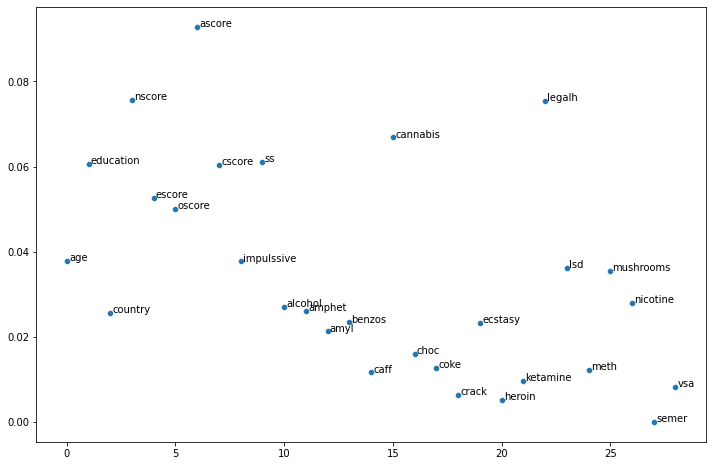

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=range(features_importances.shape[0]),
                y=features_importances.values.reshape((1,-1))[0])
for i in range(features_importances.shape[0]):
    plt.text(x = i + 0.1,
            y = features_importances.values[i],
            s='{}'.format(features_importances.index[i]))

In [ ]:
confusion_matrix(y_test, y_pred)

array([[117,  57],
       [ 67, 136]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.67      0.65       174
           1       0.70      0.67      0.69       203

    accuracy                           0.67       377
   macro avg       0.67      0.67      0.67       377
weighted avg       0.67      0.67      0.67       377



#### Validação cruzada

In [ ]:
start = time.time()

accuracies = []
precision_0, precision_1 = [], []
recall_0, recall_1 = [], []
K = 5
skf = StratifiedKFold(n_splits=K)

ada = ADASYN()
X_resampled, y_resampled = ada.fit_resample(X, Y)
for train_index, test_index in tqdm(skf.split(X_resampled, y_resampled)):
    X_air_train, X_air_test = X_resampled.values[train_index], X_resampled.values[test_index]
    y_air_train, y_air_test = y_resampled.values[train_index], y_resampled.values[test_index]
    model = RandomForestClassifier(**clf.best_params_)
    model.fit(X_air_train, y_air_train)
    y_air_pred = model.predict(X_air_test)
    #acc = accuracy_score(y_air_test, y_air_pred)
    #accuracies.append(acc)
    cm = confusion_matrix(y_air_test, y_air_pred)
    print(cm)
    # Acuracia
    acc = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    accuracies.append(acc)
    # Precisão por classe
    prec_0 = cm[0,0]/(cm[0,0] + cm[1,0])
    prec_1 = cm[1,1]/(cm[1,1] + cm[0,1])
    precision_0.append(prec_0), precision_1.append(prec_1)
    # Recall por classe
    rec_0 = cm[0,0]/(cm[0,0] + cm[0,1])
    rec_1 = cm[1,1]/(cm[1,1] + cm[1,0])
    recall_0.append(rec_0), recall_1.append(rec_1)

print('Acc: {0:.4} | Std: {1:.4}'.format(np.mean(accuracies), np.std(accuracies)))
print('Recall [0]: {0:.4} | Recall [1]: {1:.4}'.format(np.mean(recall_0), np.mean(recall_1)))
print('Precision [0]: {0:.4} | Precision [1]: {1:.4}'.format(np.mean(precision_0), np.mean(precision_1)))

end = time.time()
print(end - start)

0it [00:00, ?it/s]<ipython-input-106-c76e47611270>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_air_train, y_air_train)
1it [00:00,  1.57it/s]

[[ 41 147]
 [  7 182]]


<ipython-input-106-c76e47611270>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_air_train, y_air_train)
2it [00:01,  1.52it/s]

[[136  52]
 [ 59 130]]


<ipython-input-106-c76e47611270>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_air_train, y_air_train)
3it [00:02,  1.52it/s]

[[171  18]
 [118  70]]


<ipython-input-106-c76e47611270>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_air_train, y_air_train)
4it [00:02,  1.54it/s]

[[170  19]
 [ 76 112]]


<ipython-input-106-c76e47611270>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_air_train, y_air_train)
5it [00:03,  1.50it/s]

[[134  55]
 [ 54 134]]
Acc: 0.679 | Std: 0.05607
Recall [0]: 0.6909 | Recall [1]: 0.6663
Precision [0]: 0.7094 | Precision [1]: 0.7254
3.332651138305664


### Regressão Logistica

In [253]:
param_grid_rl = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

In [254]:
lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid_rl, cv=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [255]:
lr = LogisticRegression(**clf.best_params_)
lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=1000)

In [262]:
features_importances = pd.DataFrame(np.abs(lr.coef_[0])/np.sum(np.abs(lr.coef_[0])),
                                    columns=['importances'],
                                    index=X_train.columns)
# Ranking top 5 variáveis mais influentes sobre a árvore de decisão
features_importances.sort_values('importances', ascending=False).head()

,importances
nicotine,0.481584
alcohol,0.147213
caff,0.119986
gender,0.065694
country,0.044245


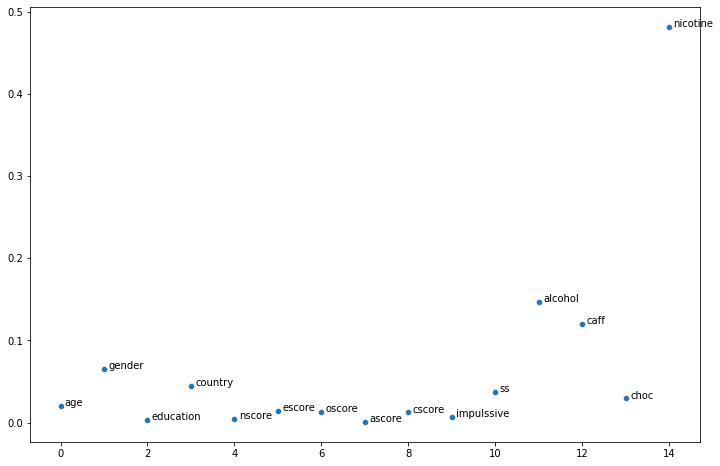

In [263]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=range(features_importances.shape[0]),
                y=features_importances.values.reshape((1,-1))[0])
for i in range(features_importances.shape[0]):
    plt.text(x = i + 0.1,
            y = features_importances.values[i],
            s='{}'.format(features_importances.index[i]))

In [265]:
confusion_matrix(y_test, y_pred)

array([[260,  38],
       [ 38, 294]])

In [266]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       298
           1       0.89      0.89      0.89       332

    accuracy                           0.88       630
   macro avg       0.88      0.88      0.88       630
weighted avg       0.88      0.88      0.88       630



In [267]:
start = time.time()

accuracies = []
precision_0, precision_1 = [], []
recall_0, recall_1 = [], []
K = 5
skf = StratifiedKFold(n_splits=K)

ada = ADASYN()
X_resampled, y_resampled = ada.fit_resample(X, Y)
for train_index, test_index in tqdm(skf.split(X_resampled, y_resampled)):
    X_air_train, X_air_test = X_resampled.values[train_index], X_resampled.values[test_index]
    y_air_train, y_air_test = y_resampled.values[train_index], y_resampled.values[test_index]
    model = LogisticRegression(**clf.best_params_)
    model.fit(X_air_train, y_air_train)
    y_air_pred = model.predict(X_air_test)
    #acc = accuracy_score(y_air_test, y_air_pred)
    #accuracies.append(acc)
    cm = confusion_matrix(y_air_test, y_air_pred)
    print(cm)
    # Acuracia
    acc = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    accuracies.append(acc)
    # Precisão por classe
    prec_0 = cm[0,0]/(cm[0,0] + cm[1,0])
    prec_1 = cm[1,1]/(cm[1,1] + cm[0,1])
    precision_0.append(prec_0), precision_1.append(prec_1)
    # Recall por classe
    rec_0 = cm[0,0]/(cm[0,0] + cm[0,1])
    rec_1 = cm[1,1]/(cm[1,1] + cm[1,0])
    recall_0.append(rec_0), recall_1.append(rec_1)

print('Acc: {0:.4} | Std: {1:.4}'.format(np.mean(accuracies), np.std(accuracies)))
print('Recall [0]: {0:.4} | Recall [1]: {1:.4}'.format(np.mean(recall_0), np.mean(recall_1)))
print('Precision [0]: {0:.4} | Precision [1]: {1:.4}'.format(np.mean(precision_0), np.mean(precision_1)))

end = time.time()
print(end - start)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

[[225  87]
 [ 72 246]]
[[282  30]
 [ 42 275]]
[[281  31]
 [ 22 295]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteratio

[[250  62]
 [ 26 291]]
[[282  30]
 [ 39 278]]
Acc: 0.8599 | Std: 0.05883
Recall [0]: 0.8462 | Recall [1]: 0.8733
Precision [0]: 0.8679 | Precision [1]: 0.8544
0.410233736038208


## Agrupamento

Perceba que ao aplicarmos um PCA, vemos que as classes estão sendo sobrepostas, dificultando basten a tarefa de agrupamento, logo sendo inviavel utiliza-la para este problema.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


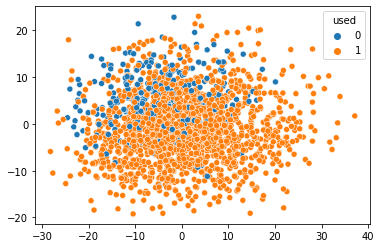

In [273]:
pca = PCA(2)
#x = pca.fit_transform(data.drop([y_name],axis=1))
x = pca.fit_transform(data[X_train.columns])
sns.scatterplot(x[:,0],x[:,1],hue=data[y_name])
plt.show()

In [274]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train)
y_pred = kmeans.predict(X_test)

In [275]:
K = 1000
rand = []

ada = ADASYN()
X_resampled, y_resampled = ada.fit_resample(X, Y)
for train_index, test_index in tqdm(skf.split(X_resampled, y_resampled)):
    X_air_train, X_air_test = X_resampled.values[train_index], X_resampled.values[test_index]
    y_air_train, y_air_test = y_resampled.values[train_index], y_resampled.values[test_index]
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X_air_train)
    y_pred = kmeans.predict(X_air_test)
    rand.append(adjusted_rand_score(y_air_test.T[0], y_pred))

5it [00:00,  6.70it/s]


In [276]:
np.mean(rand)

0.0436383576248208